In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

In [3]:
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False
sns.set(font='Microsoft YaHei')  # 解决Seaborn中文显示问题

In [4]:
# 构建poi的dataframe用于后面存储相关poi信息
# 经纬度用于（1）poi数据获取（2）merge原数据集和poi数据集
# df = pd.read_csv('http://myeconomics.cn/geek/pyfile/%E6%B7%B1%E5%9C%B3%E4%BA%8C%E6%89%8B%E6%88%BF%E5%88%86%E6%9E%90%E6%95%B0%E6%8D%AE.csv').reset_index(drop=True)
df = pd.read_csv('http://myeconomics.cn/geek/pyfile/SZershoufangdata.csv').reset_index(drop=True)
# df[['经度','纬度']] = df3[['经度','纬度']].round(6) # 由于先前将经纬度转为了float，现在统一取后六位

# 首次运行，用locations存储经纬度集合，构建poi兴趣点df
# locations = set((row[1],row[2]) for row in df3[['经度','纬度']].itertuples())
# poi = pd.DataFrame(list(locations),columns=['经度','纬度'])

In [5]:
df = df.drop(['成交时间','调价','带看','关注','浏览','房屋年限','挂牌时间','梯户比例','交易权属',
                '建筑结构','挂牌价格','成交价','成交周期','区域','子区域','套内面积','楼盘名称'],axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20541 entries, 0 to 20540
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20541 non-null  int64  
 1   经度          20541 non-null  float64
 2   纬度          20541 non-null  float64
 3   成交单价        20541 non-null  float64
 4   房屋户型        20541 non-null  object 
 5   所在楼层        20541 non-null  object 
 6   建筑面积        20541 non-null  float64
 7   户型结构        17149 non-null  object 
 8   建筑类型        20478 non-null  object 
 9   房屋朝向        19439 non-null  object 
 10  建成年代        20302 non-null  float64
 11  装修情况        20541 non-null  object 
 12  配备电梯        20483 non-null  object 
 13  房屋用途        20541 non-null  object 
 14  房权所属        18070 non-null  object 
 15  楼层数         20541 non-null  int64  
dtypes: float64(5), int64(2), object(9)
memory usage: 2.5+ MB


In [7]:
df.T.head(35)

,0,1,2,3,4,5,6,7,8,9,...,20531,20532,20533,20534,20535,20536,20537,20538,20539,20540
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,20531,20532,20533,20534,20535,20536,20537,20538,20539,20540
经度,114.134,114.14,114.133,114.139,114.088,114.14,114.147,114.146,114.116,114.14,...,114.032,114.064,114.064,114.041,114.019,114.025,114.055,114.027,114.028,114.028
纬度,22.5476,22.5555,22.5463,22.5531,22.5822,22.5536,22.5594,22.5513,22.5575,22.5796,...,22.6367,22.6072,22.6072,22.6527,22.635,22.6394,22.6795,22.6403,22.6582,22.6337
成交单价,3.7974,8.0438,4.685,5.5837,5.1901,6.8728,6.2861,3.4091,6.6522,6.5826,...,6.1043,6.052,6.5175,6.135,7.1185,7.6171,4.669,7.3149,5.0764,8.3258
房屋户型,1室1厅1厨1卫,2室1厅1厨1卫,2室1厅1厨1卫,2室1厅1厨1卫,4室2厅1厨2卫,1室1厅1厨1卫,3室1厅1厨1卫,1室0厅1厨1卫,1室1厅1厨1卫,2室1厅1厨1卫,...,4室2厅1厨2卫,3室2厅1厨1卫,3室2厅1厨2卫,5室2厅1厨2卫,3室1厅1厨2卫,4室2厅1厨2卫,3室1厅1厨1卫,2室2厅1厨1卫,1室1厅1厨1卫,3室1厅1厨2卫
所在楼层,低楼层,中楼层,高楼层,中楼层,低楼层,中楼层,中楼层,中楼层,高楼层,高楼层,...,低楼层,低楼层,中楼层,中楼层,中楼层,中楼层,高楼层,低楼层,中楼层,高楼层
建筑面积,45.69,55.82,55.71,65.37,163.39,41.25,93.54,54.56,46,72.16,...,108.94,87.08,86.69,126,87.8,87.96,85.8,54,40.58,87.44
户型结构,平层,平层,平层,平层,平层,平层,平层,NaN,NaN,平层,...,平层,NaN,平层,平层,平层,平层,平层,平层,平层,平层
建筑类型,板塔结合,塔楼,塔楼,板塔结合,板塔结合,塔楼,板塔结合,板塔结合,板塔结合,板塔结合,...,板塔结合,板塔结合,板塔结合,板塔结合,板塔结合,板塔结合,塔楼,板塔结合,板塔结合,塔楼
房屋朝向,西北,北,东南,南,南,东北,东南,东南,南,南,...,东南 南,南,东南,西南,南,西南,东南,南,南,南


In [7]:
# 异常值处理
def show_error(df,col,whis=1.5,show=False):
        '''
        显示上下限异常值数量，可选显示示例异常数据
        df：数据源
        col：字段名
        whis：默认1.5，对应1.5倍iqr
        show：是否显示示例异常数据
        '''
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        upper_bound = df[col].quantile(0.75) + whis * iqr # 上界
        lower_bound = df[col].quantile(0.25) - whis * iqr # 下界
        # print(iqr,upper_bound,lower_bound)
        print('【',col,'】上界异常值总数：',df[col][df[col] > upper_bound].count())
        if show:
            print('异常值示例：\n',df[df[col] > upper_bound].head(5).T)
        print('【',col,'】下界异常值总数：',df[col][df[col] < lower_bound].count())
        if show:
            print('异常值示例：\n',df[df[col] < lower_bound].head(5).T)
        print('- - - - - - ')
        
def drop_error(df,col,whis=1.5):
        '''
        删除上下限异常值数量
        df：数据源
        col：字段名
        whis：默认1.5，对应1.5倍iqr
        '''
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        upper_bound = df[col].quantile(0.75) + whis*iqr # 上界
        lower_bound = df[col].quantile(0.25) - whis*iqr # 下界
        data_del = df[col][(df[col] > upper_bound) | (df[col] < lower_bound)].count()
        data = df[(df[col] <= upper_bound) & (df[col] >= lower_bound)]
        print(f'【{col}】总剔除数据量：',data_del)
        return data.reset_index(drop=True)


In [8]:
# 处理空值
def fill_with_neighbor_or_mode(df,col):
    '''
    用相同经纬度的楼盘数据做填充，如果没有同类信息，则用整体众数填充。
    df：数据源
    col：字段名
    '''
#     loc = df[df[col].isna()][['经度','纬度']]
#     loclist = set((l[1],l[2]) for l in loc.itertuples())
    mode_number = df[col].mode()[0]
    df[col].fillna(mode_number, inplace=True)
    # print(mode_number)
#     for i in loclist:
#         try:
#             r = df[(df.经度 == i[0]) & (df.纬度 == i[1])][col].mode()[0]
#             df.loc[(df.经度 == i[0]) & (df.纬度 == i[1]) & df[col].isna(),col] = r
#         except Exception as e:
#             df.loc[(df.经度 == i[0]) & (df.纬度 == i[1]) & df[col].isna(),col] = mode_number
    print(f'fill_with_neighbor_or_mode - {col} , done!')

In [9]:
# 房屋户型哑变量获取
def roomtype_get_dummies(df):
    '''
    房屋户型哑变量获取
    df：数据源
    '''
    roomtype = df.房屋户型.str.extract('(?P<室>\d+)室(?P<厅>\d+)厅(?P<厨>\d+)厨(?P<卫>\d+)卫').astype(np.float)
    print('roomtype_get_dummies , done!')
    return pd.merge(df,roomtype,how='left',left_index=True,right_index=True).drop('房屋户型',axis=1)

In [10]:
# 房屋朝向哑变量获取
def orientation_get_dummies(df):
    '''
    房屋朝向哑变量获取
    df：数据源
    '''
    l = set()
    for i in df.房屋朝向.str.split(' '):
        l.update(i)
    d = pd.DataFrame(np.zeros((len(df),len(l)),dtype=np.int8),
                        columns=[f'房屋朝向_{i}' for i in l])
    df = df.join(d)
    for n in l:
        df.loc[df.房屋朝向.str.contains(n),f'房屋朝向_{n}'] = 1
    print('orientation_get_dummies , done!')
    return df.drop('房屋朝向',axis=1)

In [11]:
# 其他哑变量获取
def dummies_getting(df,col):
    '''
    其他哑变量获取
    df：数据源
    col：字段名
    '''
    df = pd.get_dummies(df,columns=col)
    print(f'dummies_getting - {col} , done!')
    return df

In [12]:
df.isnull().sum().sort_values(ascending=False)

户型结构          3392
房权所属          2471
房屋朝向          1102
建成年代           239
建筑类型            63
配备电梯            58
楼层数              0
房屋用途             0
装修情况             0
建筑面积             0
所在楼层             0
房屋户型             0
成交单价             0
纬度               0
经度               0
Unnamed: 0       0
dtype: int64

In [13]:
# 先处理空值
# df.loc[df.产权年限 == '未知','产权年限'] = np.nan
for i in ['户型结构','建筑类型','建成年代','配备电梯','房权所属', '房屋朝向']:
    fill_with_neighbor_or_mode(df,i)
# df.产权年限 = df.产权年限.str[:2].astype(np.int8)

fill_with_neighbor_or_mode - 户型结构 , done!
fill_with_neighbor_or_mode - 建筑类型 , done!
fill_with_neighbor_or_mode - 建成年代 , done!
fill_with_neighbor_or_mode - 配备电梯 , done!
fill_with_neighbor_or_mode - 房权所属 , done!
fill_with_neighbor_or_mode - 房屋朝向 , done!


In [14]:
df.isnull().sum().sort_values(ascending=False)

楼层数           0
房权所属          0
房屋用途          0
配备电梯          0
装修情况          0
建成年代          0
房屋朝向          0
建筑类型          0
户型结构          0
建筑面积          0
所在楼层          0
房屋户型          0
成交单价          0
纬度            0
经度            0
Unnamed: 0    0
dtype: int64

【 成交单价 】上界异常值总数： 1
【 成交单价 】下界异常值总数： 0
- - - - - - 
【 建筑面积 】上界异常值总数： 138
【 建筑面积 】下界异常值总数： 0
- - - - - - 
【 楼层数 】上界异常值总数： 0
【 楼层数 】下界异常值总数： 0
- - - - - - 
【 建成年代 】上界异常值总数： 1
【 建成年代 】下界异常值总数： 0
- - - - - - 


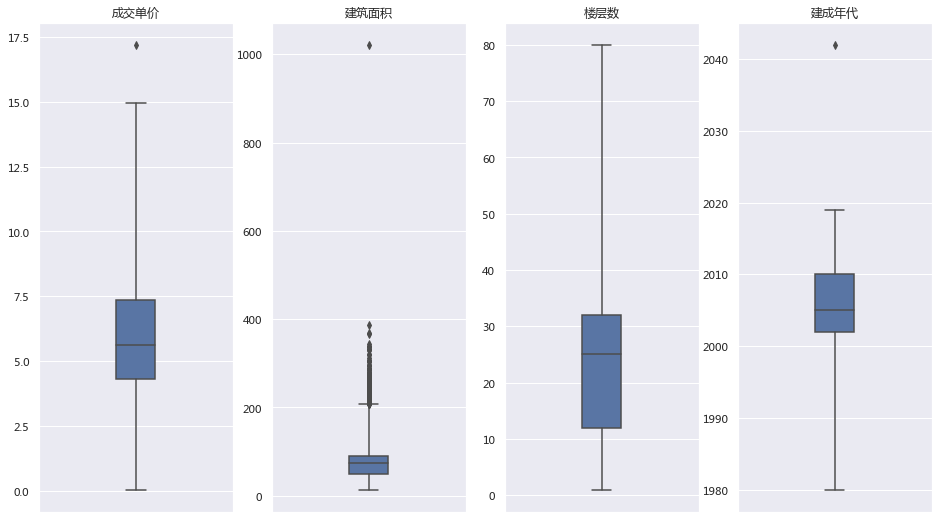

In [15]:
# 查看一下最终会保留的连续值字段异常值情况，注意这里whis是3
plt.figure(figsize=(16,9))
for n,i in enumerate(['成交单价', '建筑面积', '楼层数','建成年代']):
    plt.subplot(1,4,n+1)
    plt.title(i)
    sns.boxplot(df[i],orient='v',width=0.2,whis=3)    
    plt.ylabel('')
for i in ['成交单价', '建筑面积', '楼层数','建成年代']:        
    show_error(df,i,whis=3)  

In [16]:
# 处理异常值 
for i in ['成交单价', '建筑面积', '楼层数','建成年代']:
    df = drop_error(df,i,whis=3)    # 注意这里whis是3

【成交单价】总剔除数据量： 1
【建筑面积】总剔除数据量： 138
【楼层数】总剔除数据量： 0
【建成年代】总剔除数据量： 1


In [17]:
# 房屋户型哑变量获取
df = roomtype_get_dummies(df)

roomtype_get_dummies , done!


In [18]:
# 房屋朝向哑变量获取
df = orientation_get_dummies(df)

orientation_get_dummies , done!


In [19]:
df.T.head(50)

,0,1,2,3,4,5,6,7,8,9,...,20391,20392,20393,20394,20395,20396,20397,20398,20399,20400
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,20531,20532,20533,20534,20535,20536,20537,20538,20539,20540
经度,114.134,114.14,114.133,114.139,114.088,114.14,114.147,114.146,114.116,114.14,...,114.032,114.064,114.064,114.041,114.019,114.025,114.055,114.027,114.028,114.028
纬度,22.5476,22.5555,22.5463,22.5531,22.5822,22.5536,22.5594,22.5513,22.5575,22.5796,...,22.6367,22.6072,22.6072,22.6527,22.635,22.6394,22.6795,22.6403,22.6582,22.6337
成交单价,3.7974,8.0438,4.685,5.5837,5.1901,6.8728,6.2861,3.4091,6.6522,6.5826,...,6.1043,6.052,6.5175,6.135,7.1185,7.6171,4.669,7.3149,5.0764,8.3258
所在楼层,低楼层,中楼层,高楼层,中楼层,低楼层,中楼层,中楼层,中楼层,高楼层,高楼层,...,低楼层,低楼层,中楼层,中楼层,中楼层,中楼层,高楼层,低楼层,中楼层,高楼层
建筑面积,45.69,55.82,55.71,65.37,163.39,41.25,93.54,54.56,46,72.16,...,108.94,87.08,86.69,126,87.8,87.96,85.8,54,40.58,87.44
户型结构,平层,平层,平层,平层,平层,平层,平层,平层,平层,平层,...,平层,平层,平层,平层,平层,平层,平层,平层,平层,平层
建筑类型,板塔结合,塔楼,塔楼,板塔结合,板塔结合,塔楼,板塔结合,板塔结合,板塔结合,板塔结合,...,板塔结合,板塔结合,板塔结合,板塔结合,板塔结合,板塔结合,塔楼,板塔结合,板塔结合,塔楼
建成年代,1999,2003,2002,2000,2000,2011,1986,2003,2006,2000,...,2007,2009,2009,2018,2015,2016,2012,2011,2006,2013
装修情况,简装,精装,精装,其他,简装,精装,其他,精装,简装,精装,...,精装,精装,简装,毛坯,精装,精装,精装,精装,简装,精装


In [20]:
# 其他哑变量获取
columns = ['所在楼层','户型结构','建筑类型','装修情况','配备电梯','房屋用途','房权所属']
df = dummies_getting(df,columns)

dummies_getting - ['所在楼层', '户型结构', '建筑类型', '装修情况', '配备电梯', '房屋用途', '房权所属'] , done!


In [21]:
df.shape

(20401, 44)

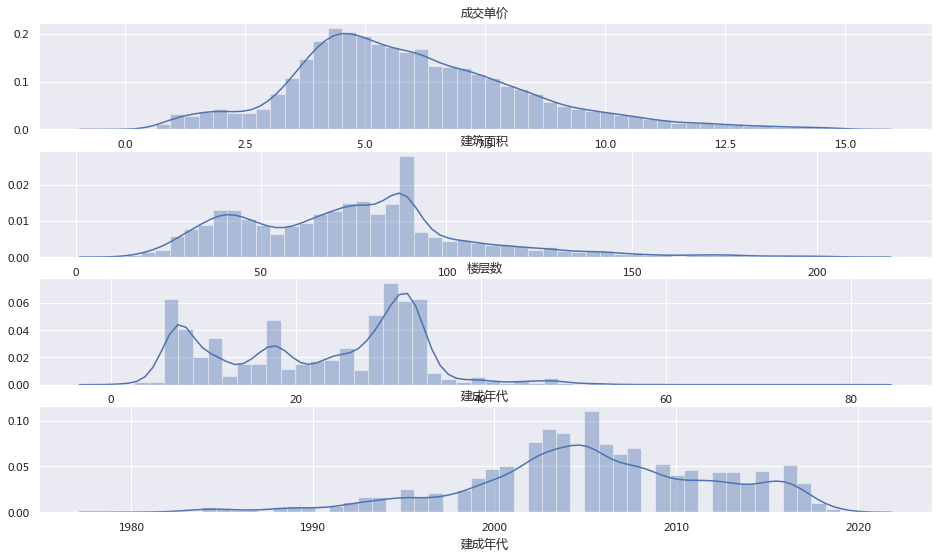

In [22]:
# 整体分布偏态情况减小
plt.figure(figsize=(16,9))
for n,i in enumerate(['成交单价', '建筑面积', '楼层数','建成年代']):
    plt.subplot(4,1,n+1)
    plt.title(i)
    sns.distplot(df[i])
    plt.ylabel('')

In [23]:
cols = ['室', '厅', '厨', '卫']
for col in cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

## 3.3 训练模型

In [24]:
X = df.drop('成交单价', axis=1)
y = df['成交单价']

In [25]:
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0.)# 如果报错，结果是0
    grid.fit(X, y)
    # 经典的性能指标
    print("Best Accuracy: {}".format(grid.best_score_))
    # 得到最佳准确率的最佳参数
    print("Best Parameters: {}".format(grid.best_params_)) # 拟合的平均时间(秒)
    print("Average Time to Fit (s):{}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3))) # 预测的平均时间(秒)
    # 从该指标可以看出模型在真实世界的性能
    print("Average Time to Score (s):{}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

In [27]:
lr = LinearRegression()
lr_params = {'fit_intercept': [True, False]}

get_best_model_and_accuracy(lr, lr_params, X, y)

Best Accuracy: 0.28276449532681813
Best Parameters: {'fit_intercept': True}
Average Time to Fit (s):0.11
Average Time to Score (s):0.011


In [28]:
tree = DecisionTreeRegressor(random_state=42)
tree_params = {
    'max_depth':[None, 1, 3, 5, 7]
}
get_best_model_and_accuracy(tree, tree_params, X, y)

Best Accuracy: 0.6231677044136115
Best Parameters: {'max_depth': 7}
Average Time to Fit (s):0.373
Average Time to Score (s):0.015


In [29]:
from sklearn.svm import LinearSVR

svr = LinearSVR(random_state=42)
svr_params = {
    'C': [1e-2, 1e-1, 1e0, 1e1, 1e2],
}
get_best_model_and_accuracy(svr, svr_params, X, y)

Best Accuracy: -2.9687520448791203
Best Parameters: {'C': 0.01}
Average Time to Fit (s):6.207
Average Time to Score (s):0.009


In [30]:
forest = RandomForestRegressor(random_state=42)
forest_params = {'max_features':['auto'], 'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 1, 3, 5, 7]}
get_best_model_and_accuracy(forest, forest_params, X, y)

Best Accuracy: 0.805333654149712
Best Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
Average Time to Fit (s):4.574
Average Time to Score (s):0.032


In [31]:
knn = KNeighborsRegressor()
knn_params = {'n_neighbors': [1, 3, 5, 7]}
get_best_model_and_accuracy(knn, knn_params, X, y)

Best Accuracy: -0.17520810117269708
Best Parameters: {'n_neighbors': 7}
Average Time to Fit (s):0.8
Average Time to Score (s):0.063


In [32]:
tree = DecisionTreeRegressor(random_state=42)
tree_params = {
    'max_depth':[7, 9, 11, 13]
}
get_best_model_and_accuracy(tree, tree_params, X, y)

Best Accuracy: 0.6737225466191447
Best Parameters: {'max_depth': 11}
Average Time to Fit (s):0.116
Average Time to Score (s):0.004


In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from copy import deepcopy

forest_pipe_params = {'model__n_estimators':[10, 50, 100, 200],
                     'model__max_depth': [None, 1, 3, 5, 7]}
k_best = SelectKBest(f_classif)
select_k_pipe = Pipeline([
    ('k_best', k_best), ('model', forest)
])
select_k_pipe_params = deepcopy(forest_pipe_params)
select_k_pipe_params.update(
    {"k_best__k": [5, 7, 10, 20, 30]}
)

get_best_model_and_accuracy(select_k_pipe, select_k_pipe_params, X, y)

Best Accuracy: 0.8053057951968674
Best Parameters: {'k_best__k': 20, 'model__max_depth': None, 'model__n_estimators': 200}
Average Time to Fit (s):3.442
Average Time to Score (s):0.029


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

select = SelectFromModel(DecisionTreeRegressor())

select_from_pipe = Pipeline([
    ("select", select),
    ("model", forest)
])
select_from_pipe_params = deepcopy(forest_pipe_params)
select_from_pipe_params.update({
    "select__threshold": [.01, .05, .1, .2, .25, .3, .4, .5, .6, "mean", "median", "2.*mean"],
    'select__estimator__max_depth': [None, 1, 3, 5, 7, 9],
})

print(select_from_pipe_params)
get_best_model_and_accuracy(select_from_pipe, select_from_pipe_params, X, y)

{'model__n_estimators': [10, 50, 100, 200], 'model__max_depth': [None, 1, 3, 5, 7], 'select__threshold': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 'mean', 'median', '2.*mean'], 'select__estimator__max_depth': [None, 1, 3, 5, 7, 9]}


KeyboardInterrupt: 

In [27]:
def get_best_model_and_accuracy2(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0.,
    n_jobs=-1)# 如果报错，结果是0
    grid.fit(X, y)
    # 经典的性能指标
    print("Best Accuracy: {}".format(grid.best_score_))
    # 得到最佳准确率的最佳参数
    print("Best Parameters: {}".format(grid.best_params_)) # 拟合的平均时间(秒)
    print("Average Time to Fit (s):{}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3))) # 预测的平均时间(秒)
    # 从该指标可以看出模型在真实世界的性能
    print("Average Time to Score (s):{}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

In [26]:
import xgboost as xgb
# xgboost模型
xgb_reg = xgb.XGBRegressor(objective='reg:linear',
                            n_job=-1,
                            booster='gbtree',
                            learning_rate=0.05)
# 参数设定
xgb_params = {'xgb__max_depth':[6,9],    
             'xgb__subsample':[0.6,0.9,1],
             'xgb__colsample_bytree':[0.5,0.6],
             'xgb__reg_alpha':[0,0.05,0.1],
             'xgb__n_estimators':[750,1000]}

# 工作流管道
pipe_xgb = Pipeline([
    ('sc',StandardScaler()),
    ('xgb',xgb_reg)
])
get_best_model_and_accuracy2(pipe_xgb, xgb_params, X, y)

NameError: name 'get_best_model_and_accuracy2' is not defined